In [ ]:
import torch
from transformers import AutoTokenizer

# カスタムクラスが必要な場合はそちらを import
# from your_module import ModernBertForScoring

MODEL_DIR = "./modernbert_jamt_finetune_ckpt_49"  # 実際のパスに置き換えてください

# もし学習時のクラスがカスタムクラス ModernBertForScoring なら
# model = ModernBertForScoring.from_pretrained(MODEL_DIR)

# もし学習時に ModernBertForSequenceClassification などを使ったなら（config.jsonを修正済み）
# from transformers import AutoModelForSequenceClassification
# model = AutoModelForSequenceClassification.from_pretrained(MODEL_DIR)

# 例：カスタムクラス ModernBertForScoring の場合
from train_jmtb_v6 import ModernBertForScoring
model = ModernBertForScoring.from_pretrained(MODEL_DIR)

tokenizer = AutoTokenizer.from_pretrained(MODEL_DIR)

# GPU利用する場合
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)
model.eval()


You are attempting to use Flash Attention 2.0 with a model not initialized on GPU. Make sure to move the model to GPU after initializing it on CPU with `model.to('cuda')`.


ModernBertForScoring(
  (model): ModernBertModel(
    (embeddings): ModernBertEmbeddings(
      (tok_embeddings): Embedding(102400, 512, padding_idx=3)
      (norm): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
      (drop): Dropout(p=0.0, inplace=False)
    )
    (layers): ModuleList(
      (0): ModernBertEncoderLayer(
        (attn_norm): Identity()
        (attn): ModernBertAttention(
          (Wqkv): Linear(in_features=512, out_features=1536, bias=False)
          (rotary_emb): ModernBertUnpaddedRotaryEmbedding(dim=64, base=160000.0, scale_base=None)
          (Wo): Linear(in_features=512, out_features=512, bias=False)
          (out_drop): Identity()
        )
        (mlp_norm): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
        (mlp): ModernBertMLP(
          (Wi): Linear(in_features=512, out_features=4096, bias=False)
          (act): GELUActivation()
          (drop): Dropout(p=0.0, inplace=False)
          (Wo): Linear(in_features=2048, out_features=512, 

In [5]:
def predict_score(text: str, model, tokenizer, device):
    """
    1つのテキストに対し、学習済みモデルで 0.0~1.0 の推定スコアを返す
    (ModernBertForScoring で Sigmoidがかかっている想定)
    """
    # トークナイズ
    inputs = tokenizer(
        text,
        return_tensors="pt",
        truncation=True,
        max_length=512
    )
    # GPUへ移動
    inputs = {k: v.to(device) for k, v in inputs.items()}

    # 推論
    with torch.no_grad():
        outputs = model(**inputs)
        # ModernBertForScoring なら outputs.logits が [batch_size,1]
        score = outputs.logits.squeeze().item()  # floatに変換

    return score

# ------------------------
# 推論テスト
# ------------------------
example_text = "これはテスト入力です。BERTに対するテストを行います。"
pred_score = predict_score(example_text, model, tokenizer, device)
print(f"Predicted score: {pred_score:.4f}")


Predicted score: 0.3882


In [6]:
import pickle

In [7]:
# 学習時に保存したデータセットpickle (floatラベル)
with open(r"/media/kurogane/kioxia1/dataset/sss/pixiv/modernbert_jamt_finetune_ckpt_49/dataset_dict_float.pkl", "rb") as file:
    dataset_dict = pickle.load(file)

# テストセットだけ取り出す (train/validation も必要なら適宜呼び出す)
test_dataset = dataset_dict["test"]


In [8]:
test_dataset

Dataset({
    features: ['input_text', 'label'],
    num_rows: 648
})

In [9]:
from tqdm import tqdm

In [10]:
l_estimate_scores = []
for i_dataset in tqdm(test_dataset):
    # print(i_dataset)
    f_estimate_score = predict_score(i_dataset['input_text'], model, tokenizer, device)
    l_estimate_scores.append([f_estimate_score, i_dataset["label"]])

100%|██████████| 648/648 [00:04<00:00, 132.07it/s]


In [11]:
l_estimate_scores

[[0.8853596448898315, 0.9],
 [0.7726119756698608, 0.9],
 [0.9444791674613953, 0.8],
 [0.8277913928031921, 0.9],
 [0.650458574295044, 0.6],
 [0.9936065673828125, 1.0],
 [0.8900719881057739, 1.0],
 [0.9954805374145508, 0.9],
 [0.8674108386039734, 1.0],
 [0.6612706184387207, 0.6],
 [0.7883831262588501, 0.9],
 [0.8626026511192322, 0.9],
 [0.8753176927566528, 0.9],
 [0.8415157794952393, 1.0],
 [0.8576846718788147, 0.9],
 [0.8369491100311279, 0.8],
 [0.6891637444496155, 0.4],
 [0.5401517152786255, 0.8],
 [0.6221821308135986, 0.7],
 [0.7067455053329468, 0.9],
 [0.862845778465271, 0.9],
 [0.754692554473877, 0.9],
 [0.8646848797798157, 0.9],
 [0.8190110325813293, 0.7],
 [0.8598576784133911, 0.7],
 [0.1510585993528366, 0.2],
 [0.3246677815914154, 0.2],
 [0.47619491815567017, 0.7],
 [0.6976843476295471, 0.7],
 [0.7661383152008057, 0.8],
 [0.8208702802658081, 0.9],
 [0.8893846869468689, 0.7],
 [0.7436974048614502, 0.8],
 [0.8706310987472534, 0.9],
 [0.7577768564224243, 0.6],
 [0.4159798324108124, 

MSE : 0.023660880108473913
RMSE: 0.1538209352086832
MAE : 0.10959695647068231
R^2 : 0.6317264634099204


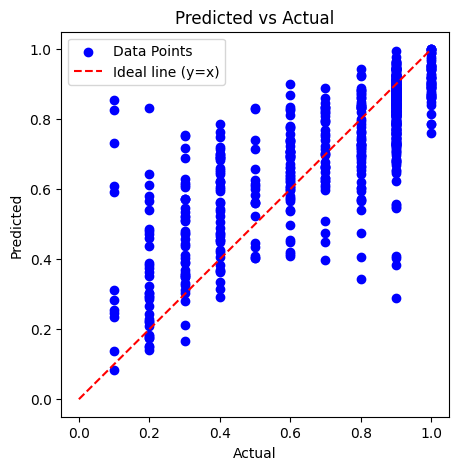

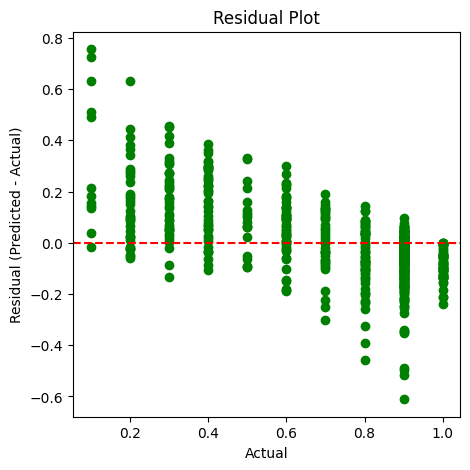

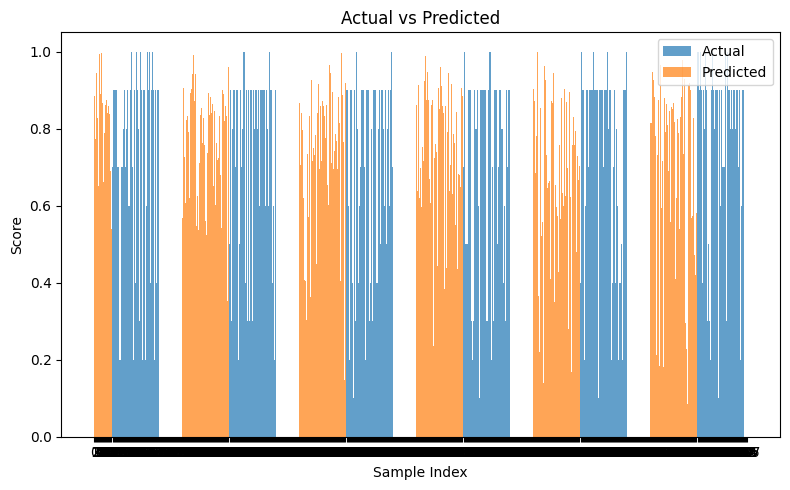

In [12]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score


# 予測値(predicted)、実際値(actual)に分割
predicted = [x[0] for x in l_estimate_scores]
actual = [x[1] for x in l_estimate_scores]

# --- 評価指標の計算 ---
mse = mean_squared_error(actual, predicted)
rmse = np.sqrt(mse)
mae = mean_absolute_error(actual, predicted)
r2 = r2_score(actual, predicted)

print("MSE :", mse)
print("RMSE:", rmse)
print("MAE :", mae)
print("R^2 :", r2)

# --- 散布図 (Predicted vs Actual) ---
plt.figure(figsize=(5, 5))
plt.scatter(actual, predicted, color='blue', label='Data Points')
# y = x の目安線
plt.plot([0, 1], [0, 1], 'r--', label='Ideal line (y=x)')
plt.xlabel('Actual')
plt.ylabel('Predicted')
plt.title('Predicted vs Actual')
plt.legend()
plt.show()

# --- 残差プロット (Residual plot) ---
residuals = [p - a for p, a in zip(predicted, actual)]

plt.figure(figsize=(5, 5))
plt.scatter(actual, residuals, color='green')
plt.axhline(0, color='red', linestyle='--')  # 残差が0となるライン
plt.xlabel('Actual')
plt.ylabel('Residual (Predicted - Actual)')
plt.title('Residual Plot')
plt.show()

# --- サンプルごとのバー比較 ---
indices = range(len(actual))
bar_width = 0.4

plt.figure(figsize=(8, 5))
plt.bar(indices, actual, width=bar_width, label='Actual', alpha=0.7)
plt.bar([i + bar_width for i in indices], predicted, width=bar_width, label='Predicted', alpha=0.7)

plt.xlabel('Sample Index')
plt.ylabel('Score')
plt.title('Actual vs Predicted')
plt.xticks([i + bar_width/2 for i in indices], indices)  # 棒の中央にインデックスを合わせる
plt.legend()
plt.tight_layout()
plt.show()
